## Complementarity & Accessibilty

### 1.  Imports & Declarations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from sklearn.cluster import DBSCAN
# from haversine import haversine as hs
import requests
%matplotlib inline
# from pydantic_settings import BaseSettings
from ydata_profiling import ProfileReport

import sys
sys.path.append('../utils/')
from functions import get_zone_info
from functions import haversine_distance as hsd

In [2]:
##############################################################################################################
# GREEN MOBILITY
##############################################################################################################

# Initialize dataframe
file_path = "../data/processed/gm_raw.csv"
gm_source = pd.read_csv(file_path)

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.

# Add columns if necessary

#################################################################################################################
# DRIVE NOW
#################################################################################################################

# 1. Initialize dataframe
file_path = "../data/raw/DriveNow/DTU - data til case_LTMZones1.csv"
sn_source = pd.read_csv(file_path, sep=";")

# 2. Rename columns if necessary
sn_source.rename(columns= {
                            "Latitude (Start)": "LatitudeStart", 
                            "Longitude (Start)": "LongitudeStart", 
                            'Latitude (Slut)': "LatitudeEnd", 
                            'Longitude (Slut)':'LongitudeEnd',
                            'Reservationstidspunkt': "ReservationTime",
                            'Start tidspunkt': "StartTime",
                            'Slut tidspunkt': "EndTime",
                            'Alder': "Age",
                            'Køn': "Gender",
                            'Batteristatus (start)': "BatteryStart",
                            'Batteristatus (slut)':"BatteryEnd",
                            'Km kørt': "KmDriven"
                            }, inplace=True)

# 3. Drop columns if necessary
sn_source.drop(columns=['TurID'],inplace=True)

# 4. Convert to appropriate data types
# Convert to Numeric the following columns:
coordinates = [
    'LatitudeEnd',
    'LatitudeStart',
    'LongitudeEnd',
    'LongitudeStart'
]

for col in coordinates:
    sn_source[col] = sn_source[col].apply(lambda x: x.replace(',','.'))
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

target_ls = [
    'KmDriven',
    'BatteryStart',
    'BatteryEnd',
]
for col in target_ls:
    sn_source[col] = pd.to_numeric(sn_source[col],errors='coerce')

sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


# 5. Auxiliary columns
sn_source['TripDurationHours'] = (sn_source['EndTime'] - sn_source['StartTime']).dt.total_seconds()/3600
sn_source['TripDurationMinutes'] = sn_source['TripDurationHours']*60  #   trip duration in min
sn_source['AvgSpeed'] = sn_source['KmDriven']/sn_source['TripDurationHours'] #   avg speed

sn_source['Month'] = sn_source['StartTime'].dt.strftime("%B").astype('category')  #   month
sn_source['Weekday'] = sn_source['StartTime'].dt.day_name().astype('category')    #   day of the week
sn_source['StartHour'] = sn_source['StartTime'].dt.hour.astype('category')    #   hour of the day

# 6. Descriptive statistics
sn_source.describe()

# 7. Drop outliers, missing values, etc.

# drop rows with missing values
sn_source.dropna(inplace=True)

# drop rows with BatteryEnd more than BatteryStart
sn_source = sn_source[sn_source['BatteryStart'] >= sn_source['BatteryEnd']]

# drop rows with coordinates equal to 0 
for col in coordinates:
    sn_source = sn_source[(sn_source[col] != 0)|(sn_source[col] != '')]


# replace negative BatteryEnd with 0
sn_source['BatteryEnd'] = sn_source['BatteryEnd'].apply(lambda x: 0 if x < 0 else x)

# # drop rows with negative and avg speed > 100 km/h
sn_source = sn_source[(sn_source['AvgSpeed'] > 1) & (sn_source['AvgSpeed'] < 100)]


# # 8. Add columns if necessary
# # Add haversise distance to the dataframe
sn_source['HaversineDistance'] = hsd(sn_source['LatitudeStart'], sn_source['LongitudeStart'],sn_source['LatitudeEnd'], sn_source['LongitudeEnd'])
# sn_source['HaversineDistance'] = sn_source['HaversineDistance'].apply(lambda x: round(x,0))

# # drop rows with Haversine distance > 1000 km
sn_source = sn_source[sn_source['HaversineDistance'] < 1000]

##################################################################################################################
# DONKEY REPUBLIC
##################################################################################################################


# Initialize Donkey Republic dataframe
# file_path = ""
# donkey_source = ""

# Rename columns if necessary

# Drop columns if necessary

# Descriptive statistics

# Drop outliers, missing values, etc.



/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_35638/1770929939.py:25: DtypeWarning: Columns (12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  sn_source = pd.read_csv(file_path, sep=";")
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_35638/1770929939.py:67: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['EndTime'] = pd.to_datetime(sn_source['EndTime'], errors='coerce')    #   to DateTime
/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_35638/1770929939.py:68: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  sn_source['StartTime'] = pd.to_datetime(sn_source['StartTime'], errors='coerce')    #   to Datetime


## Visualizations

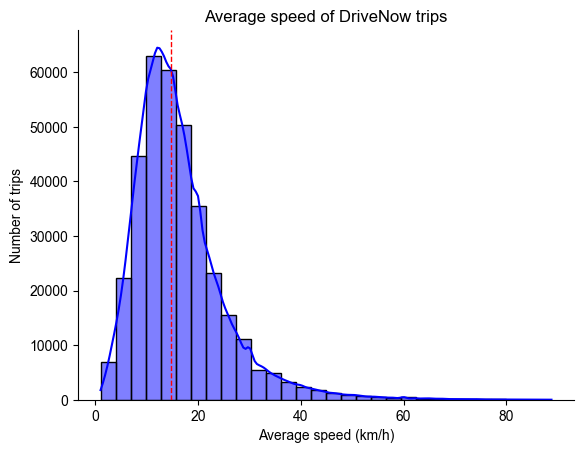

In [4]:
# plot histogram of average speed between 0 and 90 km/h using seaborn 
sns.histplot(data=sn_source[(sn_source['AvgSpeed']>0) & (sn_source['AvgSpeed']<90)], x="AvgSpeed", bins=30, color='blue', kde=True)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')

sns.despine()

# add title and labels
plt.title("Average speed of DriveNow trips")
plt.xlabel("Average speed (km/h)")
plt.ylabel("Number of trips")
plt.grid(False)
# plt.show()

# show median on the plot
plt.axvline(x=sn_source['AvgSpeed'].median(), color='red', linestyle='--', linewidth=1)
plt.show()

#### 2.1 Short Trips ShareNow: Clustering and Analysis

In [11]:
# Define short trips :: trips with distance between 5 and 40 km
sn_shorttrips = sn_source[(sn_source['KmDriven'] < 40)&(sn_source['KmDriven']>=3)]

# print the percentage of short trips using f string

print(f'{sn_shorttrips.shape[0]/sn_source.shape[0]}')

0.8723156434718756


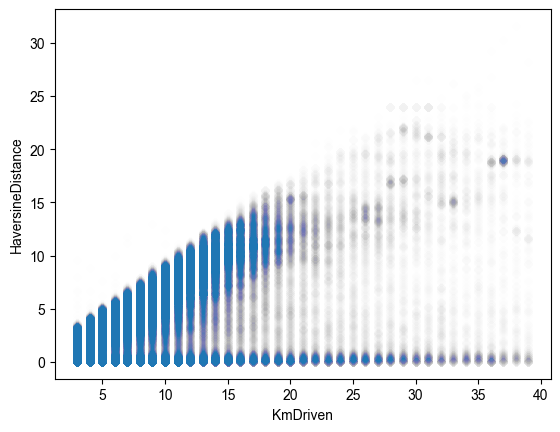

In [12]:
sns.scatterplot(data=sn_shorttrips, x="KmDriven", y="HaversineDistance", alpha=0.005)
# change color of histogram
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

In [7]:
# run DBSCAN clustering algorithm on KmDriven and HaversineDistance

db = DBSCAN(eps=5, min_samples=2).fit(sn_shorttrips[['KmDriven','HaversineDistance']])

# add the cluster labels to the dataframe
sn_shorttrips['Cluster'] = db.labels_

: 

### ShareNow Short Trips :: Clusters on scatter plot

In [ ]:
sns.scatterplot(data=sn_shorttrips, x="KmDriven", y="HaversineDistance", hue="Cluster", alpha=0.005)
sns.set_palette('Blues_r')
sns.set_style('whitegrid')
plt.grid(False)
plt.show()

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18])

/var/folders/77/lfxftc1s7_bch_43_w38l1zh0000gn/T/ipykernel_88003/1427624344.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)


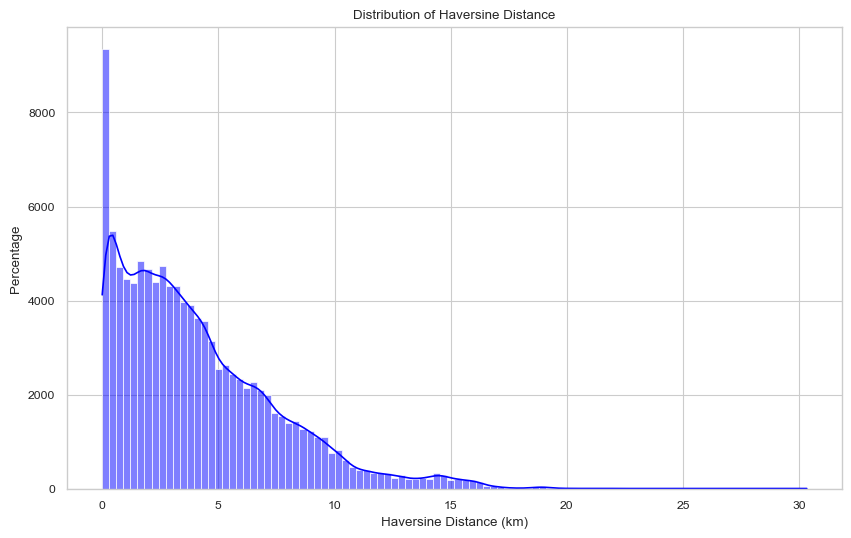

In [ ]:
# distribution of haversine distance visuzaliations
plt.figure(figsize=(10,6))
sns.set_style('whitegrid')
sns.set_palette('Blues_r')
sns.despine()
sns.histplot(gm_data['HaversineDistance'], bins=100, color='blue', palette='Blues_r', kde=True)
plt.ylabel('Percentage')
# plt.yticks(np.arange(0, 0.06, 0.01))
# plt.gca().yaxis.set_major_formatter('{:.0f}%'.format)
plt.xlabel('Haversine Distance (km)')
plt.title('Distribution of Haversine Distance')
plt.grid(False)
plt.show()

In [ ]:
# Generate the profile report
profile = ProfileReport(sn_source, title='Pandas Profiling Report', explorative=True)

# Or to view it in a Jupyter Notebook
profile.to_notebook_iframe()


In [ ]:
sn_source[['LatitudeEnd','LatitudeStart','LongitudeEnd','LongitudeStart']]

,LatitudeEnd,LatitudeStart,LongitudeEnd,LongitudeStart
2,"55,775655","55,692382","12,513962","12,583143"
3,"55,706866","55,630274","12,587122","12,648864"
4,"55,677484","55,693602","12,489247","12,53821"
5,"55,630263","55,700745","12,648955","12,473436"
6,"55,692454","55,680014","12,504951","12,507755"
...,...,...,...,...
365424,"55,665031","55,668776","12,516615","12,516638"
365442,"55,656599","55,665624","12,487849","12,483596"
365448,"55,671479","55,676891","12,533911","12,538845"
365464,"55,671468","55,672062","12,534098","12,495884"


## STATISTICAL ANALYSIS : Hypothesis testing

In [ ]:
from math import pi

# Earth's radius in meters
earth_radius = 6371000

# Epsilon value in meters
eps_meters = 400

# Conversion of epsilon from meters to radians
eps_radians = eps_meters / (2 * pi * earth_radius)


from sklearn.cluster import DBSCAN
import numpy as np

# Assuming station_coords is a dict with station names as keys and coordinates as values
coords = np.array(list(station_coords.values()))

# DBSCAN expects the data to be in a NumPy array of shape (n_samples, n_features)
# In this case, our features are the latitude and longitude
db = DBSCAN(eps=eps_radians, min_samples=1, metric='haversine').fit(np.radians(coords))

# The labels_ attribute contains the cluster labels for each point
clusters = db.labels_

# To get a list of stations for each hub
hub_stations = {}
for station, cluster in zip(station_coords.keys(), clusters):
    if cluster not in hub_stations:
        hub_stations[cluster] = []
    hub_stations[cluster].append(station)

In [ ]:
import networkx as nx

In [ ]:
G = nx.DiGraph()
G.add_edge('s','a',capacity=10)
G.add_edge('s','b',capacity=4)
G.add_edge('s','c',capacity=5)
G.add_edge('a','d',capacity=3)
G.add_edge('a','b',capacity=12)
G.add_edge('b','c',capacity=1)
G.add_edge('b','d',capacity=5)
G.add_edge('b','e',capacity=11)
G.add_edge('c','e',capacity=2)
G.add_edge('c','f',capacity=7)
G.add_edge('f','e',capacity=1)
G.add_edge('d','t',capacity=8)
G.add_edge('e','t',capacity=10)

cut_value, partition = nx.minimum_cut(G, 's', 't')
reachable, non_reachable = partition
print('Cut value:', cut_value)
print('Partition:', partition)
print('Reachable nodes:', reachable)


Cut value: 17
Partition: ({'s', 'c', 'f'}, {'e', 'b', 'd', 't', 'a'})
Reachable nodes: {'s', 'c', 'f'}


In [ ]:
sn_source[(sn_source['KmDriven'] < 40)&(sn_source['KmDriven']>5)].shape

(189078, 23)